# Attention 机制详解：MHA, MQA, GQA

我们先介绍多头注意力机制的参数变化情况(假设输入是“大家好”)：

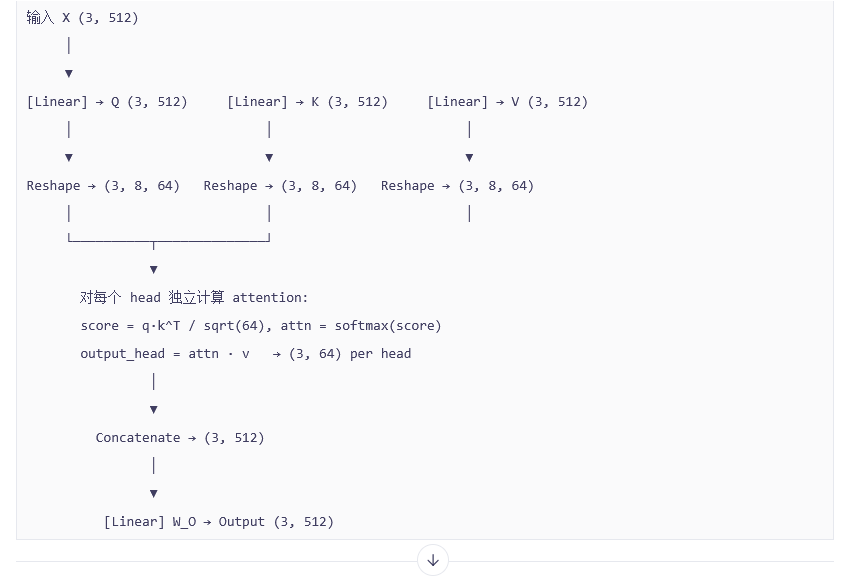

针对于上图大家也可以额外思考几个问题：  
+ 1. 相对位置编码ROPE 或 绝对位置编码在哪部分起作用的？
+ 2. 单头注意力和多头注意力区别在哪里？参数数量一样吗？
+ 3. score矩阵的维度和什么相关？

本文档详细介绍三种主流注意力机制的数学原理、区别以及参数量分析。

## 1. 基础数学原理

Transformer 中的注意力机制（Scaled Dot-Product Attention）的标准公式为：

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

其中：
- $Q$ (Query): 查询矩阵
- $K$ (Key): 键矩阵
- $V$ (Value): 值矩阵
- $d_k$: 每个 head 的维度

输入向量 $x$ (维度 $d_{model}$) 通过线性投影矩阵 $W_Q, W_K, W_V$ 映射得到 $Q, K, V$。

---

## 2. 三种机制的对比

假设模型参数如下：
- $D$: 模型隐藏层维度 (d_model)
- $H$: Head 的数量 (n_heads)
- $d_k$: 每个 Head 的维度 ($d_k = D / H$)
- $G$: GQA 中的分组数量 (n_groups)

### 2.1 MHA (Multi-Head Attention)
参考：[Attention Is All You Need](https://arxiv.org/abs/1706.03762)  
- **原理**: 每个 Head 都有自己独立的 $Q, K, V$ 投影矩阵。
- **KV Cache**: 需要存储所有 Head 的 K 和 V。大小为 $B \times L \times H \times d_k$。
- **参数量**:
  - $W_Q$: $D \times (H \cdot d_k) = D \times D$
  - $W_K$: $D \times (H \cdot d_k) = D \times D$
  - $W_V$: $D \times (H \cdot d_k) = D \times D$
  - $W_O$: $(H \cdot d_k) \times D = D \times D$
  - **Total**: $4D^2$ (忽略 Bias)

### 2.2 MQA (Multi-Query Attention)
参考：[Fast Transformer Decoding: One Write-Head is All You Need](https://arxiv.org/abs/1911.02150)  
- **原理**: 所有 Head 共享**同一组** $K$ 和 $V$ 投影矩阵，但 $Q$ 依然是多头的。
- **KV Cache**: 只需要存储一份 K 和 V。大小为 $B \times L \times 1 \times d_k$。**显存节省 $H$ 倍**。
- **参数量**:
  - $W_Q$: $D \times D$ (不变)
  - $W_K$: $D \times d_k = D \times (D/H) = D^2/H$
  - $W_V$: $D \times d_k = D^2/H$
  - $W_O$: $D \times D$
  - **Total**: $2D^2 + 2D^2/H$

### 2.3 GQA (Grouped-Query Attention)
参考：[GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints](https://arxiv.org/abs/2305.13245)  
- **原理**: 将 Head 分为 $G$ 组，每组共享一对 $K, V$。$1 < G < H$。
  - 当 $G=1$ 时，退化为 MQA。
  - 当 $G=H$ 时，退化为 MHA。
- **KV Cache**: 大小为 $B \times L \times G \times d_k$。显存节省 $H/G$ 倍。
- **参数量**:
  - $W_Q$: $D \times D$
  - $W_K$: $D \times (G \cdot d_k) = D \times (G \cdot D/H) = D^2 \cdot (G/H)$
  - $W_V$: $D \times (G \cdot d_k) = D^2 \cdot (G/H)$
  - $W_O$: $D \times D$
  - **Total**: $2D^2 + 2D^2 \cdot (G/H)$

## 3. 代码实现与参数量验证

下面我们用 PyTorch 实现一个通用的 Attention 类，来验证上述参数量公式。

In [ ]:
import torch
import torch.nn as nn
import math

class GeneralAttention(nn.Module):
    def __init__(self, d_model, n_heads, n_kv_heads=None):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        # 如果不指定 n_kv_heads，默认等于 n_heads (即 MHA)
        # MQA: n_kv_heads = 1
        # GQA: 1 < n_kv_heads < n_heads
        self.n_kv_heads = n_kv_heads if n_kv_heads is not None else n_heads
        
        # Check dimensions
        assert d_model % n_heads == 0, "d_model必须能被n_heads整除"
        assert n_heads % self.n_kv_heads == 0, "n_heads必须能被n_kv_heads整除"
        
        self.q_proj = nn.Linear(d_model, n_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(d_model, self.n_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(d_model, self.n_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(n_heads * self.head_dim, d_model, bias=False)

    def forward(self, x):
        # 这里省略具体的 forward 计算逻辑，主要关注参数量
        pass

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

# 设定参数
d_model = 1024
n_heads = 16
head_dim = d_model // n_heads # 64

print(f"Config: d_model={d_model}, n_heads={n_heads}, head_dim={head_dim}")
print("-" * 50)

# 1. MHA: n_kv_heads = n_heads = 16
mha = GeneralAttention(d_model, n_heads, n_kv_heads=n_heads)
mha_params = mha.count_parameters()
print(f"MHA Params: {mha_params:,}")

# 理论计算: 4 * d_model^2
expected_mha = 4 * (d_model ** 2)
print(f"MHA Theory: {expected_mha:,}")
print("-" * 50)

# 2. MQA: n_kv_heads = 1
mqa = GeneralAttention(d_model, n_heads, n_kv_heads=1)
mqa_params = mqa.count_parameters()
print(f"MQA Params: {mqa_params:,}")

# 理论计算: 2 * d_model^2 + 2 * d_model * head_dim
expected_mqa = 2 * (d_model ** 2) + 2 * d_model * head_dim
print(f"MQA Theory: {expected_mqa:,}")
print("-" * 50)

# 3. GQA: n_kv_heads = 4 (Group size = 16/4 = 4)
gqa = GeneralAttention(d_model, n_heads, n_kv_heads=4)
gqa_params = gqa.count_parameters()
print(f"GQA Params: {gqa_params:,}")

# 理论计算: 2 * d_model^2 + 2 * d_model * (n_kv_heads * head_dim)
expected_gqa = 2 * (d_model ** 2) + 2 * d_model * (4 * head_dim)
print(f"GQA Theory: {expected_gqa:,}")

Config: d_model=1024, n_heads=16, head_dim=64
--------------------------------------------------
MHA Params: 4,194,304
MHA Theory: 4,194,304
--------------------------------------------------
MQA Params: 2,228,224
MQA Theory: 2,228,224
--------------------------------------------------
GQA Params: 2,621,440
GQA Theory: 2,621,440


## 4. Q&A 详解

### Q: 单头和多头的参数量一样吗？

**A: 在标准设置下，是一样的。**

前提条件是：**总的 Hidden Dimension ($d_{model}$) 保持不变**。

#### 解释：
假设 $d_{model} = 512$。

1.  **单头 (Single-Head)**:
    - Head 维度 $d_k = 512$。
    - $W_Q$ 形状: $512 \times 512$。
    - 参数量: $512^2 = 262,144$。

2.  **多头 (Multi-Head, e.g., 8 heads)**:
    - 每个 Head 的维度 $d_k = 512 / 8 = 64$。
    - 我们有 8 个 $W_{Q_i}$ 矩阵，每个形状为 $512 \times 64$。
    - 总参数量: $8 \times (512 \times 64) = 512 \times (8 \times 64) = 512 \times 512 = 262,144$。

**结论**：多头注意力通过将大矩阵拆分为多个小矩阵并行计算，捕捉不同的子空间特征，但在参数总量上与单头是一致的（只要 $H \times d_k = d_{model}$）。

### Q: 参数量的增长和哪些变量呈什么关系？

我们主要关注 Projection 层的参数。

1.  **与 $d_{model}$ 的关系**：
    - 呈 **平方 ($O(d_{model}^2)$)** 关系。因为 $W$ 矩阵通常是 $d_{model} \times d_{model}$。

2.  **与 $n_{heads}$ (头数) 的关系**：
    - **MHA**: **无关**。只要 $d_k$ 随头数相应减小，总参数量不变。
    - **MQA和GQA**: **相关**。$W_K, W_V$ 形状为 $D \times (D/H)$。随着 $H$ 增加，KV 参数量减小。

3.  **与 $G$ (GQA 分组数) 的关系**：
    - 呈 **线性** 关系（在 KV 部分）。KV 参数量 $\propto G$。

### 总结

| 变量 | 变动方向 | MHA 参数量 | MQA 参数量 | GQA 参数量 |
| :--- | :--- | :--- | :--- | :--- |
| $d_{model}$ | 增加 | 增加 ($O(D^2)$) | 增加 ($O(D^2)$) | 增加 ($O(D^2)$) |
| $n_{heads}$ ($D$ 固定) | 增加 | **不变** | **减少** | **减少** (假设 G 固定) |
| $n_{groups}$ (GQA) | 增加 | N/A | N/A | **增加** |